In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from __init__ import *

utils.rng.set_seed()
device = utils.gpu.set_devices(3)

In [3]:
# Import data
train = datasets.get_mnist('balanced')
test = datasets.get_mnist('balanced', train=False)

# Get data parameters
N = len(train)
M = np.prod(train.size)

# Set training parameters and loader
batch_size = 32
epochs = 12
nu = 0.0001
loader = torch.utils.data.DataLoader(
    train, batch_size=batch_size, shuffle=True, pin_memory=True
)

# Initialize experiment dictionaries
loss_trace = {}
nets = {}
opts = {}

# Set experiment name
experiment_name = 'act_softmax'

In [4]:
# Initialize dimensions, models, parameters and optimizers
dims = [M, 835, 835, len(train.classes)]

model_kwargs = {
    'activation_params': {},
    'device': device
}

nets = {
    "Softmax": modules.AdjointSequential(
        models.dense.AdjointDense(dims, activation=nn.ReLU, **model_kwargs),
        nn.Softmax(-1),
    ).to(device),
    "DSM_a140": modules.AdjointSequential(
        models.dense.AdjointDense(dims, activation=nn.ReLU, **model_kwargs),
        modules.DirichletSoftmax(len(train.classes), alpha=1.4),
    ).to(device),
}

# Initialize with same parameters
for k, model in nets.items():
    loss_trace[k] = {}
    if k != 'Softmax':
        nets[k][0].net.V.weight.data = nets['Softmax'][0].net.V.weight.data.clone()
        nets[k][0].net.W1.weight.data = nets['Softmax'][0].net.W1.weight.data.clone()
        nets[k][0].net.U.weight.data = nets['Softmax'][0].net.U.weight.data.clone()
    opts[k] = torch.optim.Adam(model.parameters() , lr=nu)
    

In [5]:
# Define objective function

def objective_function(x, xh, params=None, l2_lambda=1e-6, reduction='mean'):
    losses = {}

    if params is not None:
        losses['l2'] = torch.tensor(0.).to(x.device)
        for param in params:
            losses['l2'] += torch.norm(param)
        losses['l2'] *= l2_lambda
    
    losses['lx'] = F.binary_cross_entropy(xh, x, reduction=reduction)
    losses['l'] = sum(losses.values())
    return losses['l'], losses

In [6]:
# Print no. parameters
print("Number of Parameters:")
for k in nets.keys():
    print(f"No. params {k:8}:  {utils.metrics.no_parameters(nets[k])}")

Number of Parameters:
No. params Softmax :  1393662
No. params DSM_a140:  1393662


In [7]:
# Set examples for training, testing and visualization
sample_indices_small = np.array([0, 3, 42, 85, 666, 1001, 6969, 31415])

# Convert sample indices to tensors
xims = torch.tensor(train.data[sample_indices_small]).float() / 255
xs = xims.flatten(-2, -1).to(device)
xt = torch.tensor(test.data).float().flatten(-2, -1).to(device) / 255

index_matrix = torch.eye(len(train.classes)).to(device)
yt = index_matrix[test.targets]

In [8]:
# Training loop

for e in range(epochs):
    i = 0
    for x, _y in loader:
        x = x[:,0,:,:].flatten(-2, -1).to(device)
        y = index_matrix[_y]
        xhs = {}
        ldicts = {}
        
        for m, cur in enumerate(nets):
            # Reset gradients and do forward pass
            opts[cur].zero_grad()
            yh = nets[cur](x)
            
            if cur.startswith('DSM'):
                yh = yh[0]
            
            # Calculate loss
            loss, ldicts[cur] = objective_function(y, yh)

            loss.backward()
            opts[cur].step()
            
            # Validation
            with torch.no_grad():
                yht = nets[cur](xt)
                if cur.startswith('DSM'):
                    yht = yht[0]
                ldicts[cur]['lt'] = F.binary_cross_entropy(yht.clip(0, 1), yt, reduction='mean').cpu()

            # Reporting
            for k, v in ldicts[cur].items():
                
                if k not in loss_trace[cur]:
                    loss_trace[cur][k] = []

                loss_trace[cur][k].append(v.cpu())


        # Plot and Report
        if i % 50 == 0:
            clear_output(wait=True)
            for cur in nets.keys():
                with torch.no_grad():
                    #ys = nets[cur](xs)
                    print(utils.reporting.generate_report(cur, e, i, ldicts[cur]))
            
        i += 1

m Softmax    e   11 i   3500 lx 7.913E-03 l 7.913E-03 lt 1.564E-02 
m DSM_a140   e   11 i   3500 lx 1.265E-02 l 1.265E-02 lt 3.397E-02 


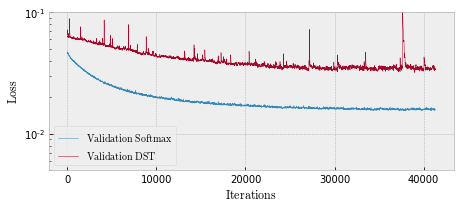

In [20]:
# Convert trace to numpy
np_loss_trace = {}
for k in loss_trace:
    np_loss_trace[k] = {}
    for l in loss_trace[k]:
        np_loss_trace[k][l] = np.array([v.item() for v in loss_trace[k][l]])

# Plot overall loss
for k in nets.keys():
    ws = 1001
    mu, std = utils.metrics.rolling_stats(np_loss_trace[k]["lx"], winsize=ws) 

    if k.startswith('DSM'):
        kname = 'DST'
    else:
        kname = k

    p = plt.plot(
        np_loss_trace[k]["lt"][ws//2:-ws//2], 
        linewidth=.5, 
        label=f"$\mathrm{{Validation\,\,{kname}}}$", 
        alpha=1, 
    )
    color = p[0].get_color()
    # plt.fill_between(
    #     np.arange(len(mu[ws//2:-ws//2])), 
    #     (mu - 1*std)[ws//2:-ws//2], 
    #     (mu + 1*std)[ws//2:-ws//2],
    #     color=color, 
    #     alpha=0.2,
    # )    
        
plt.legend()
plt.xlabel('$\mathrm{Iterations}$')
plt.ylabel('$\mathrm{Loss}$')
plt.ylim(0.005, 0.1)
plt.yscale("log")
plt.savefig(f'../figures/training/{experiment_name}.pdf')

In [10]:
# Move models to CPU
for cur, model in nets.items():
    nets[cur] = model.to('cpu')
    nets[cur].eval()
    nets[cur].train(False)
    del model
    
    
torch.cuda.empty_cache()

In [11]:
# Calculate relative error on test data
test_tensor = torch.tensor(test.data.astype(float) / 255).flatten(-2, -1).float()

print(f"Relative Error:")
for k, model in nets.items():
    yth = model(test_tensor)
    if k.startswith('DSM'):
        yth = yth[0]
    print(
        f"{k:8}: " + 
        f"RE {utils.metrics.relative_error(yt.cpu(), yth, reduction='mean'):4E} " +
        f"BCE {F.binary_cross_entropy(yth, yt.cpu(), reduction='mean'):4E} " +
        f"Acc {utils.metrics.top_k_accuracy(yth, yt, k=1):4E} " +
        f"Ac5 {utils.metrics.top_k_accuracy(yth, yt):4E} "
    )

Relative Error:
Softmax : RE 2.436241E-01 BCE 1.577098E-02 Acc 8.579255E-01 Ac5 9.882447E-01 
DSM_a140: RE 3.187726E-01 BCE 3.390207E-02 Acc 8.307447E-01 Ac5 9.824468E-01 


In [12]:
# Calculate actual Lipshitz constants / spectral norms
print("Lipschitz Constants:")
for k, model in nets.items():
    dct = model[0].get_weight_dict()
    lipschitz_constants = torch.tensor([
        torch.svd(w)[1][0]
        for w in dct.values()
    ])
    lipschitz_product = torch.prod(lipschitz_constants)

    # To account for activation, we need to multiply by the Lipschitz constants
    # The softmax function has an approx upper Lipschitz bound of sqrt(K-1)/K

    lipschitz_product *= (dims[-1] - 1)**.5 / dims[-1]
    print(f'{k:8} {lipschitz_product.item():5E}')

Lipschitz Constants:
Softmax  8.296119E+03
DSM_a140 3.817129E+04


In [13]:
# Move models to GPU
for k in nets:
    nets[k] = nets[k].to(device)

# Calculate estimated Jacobian from test data
# NOTE: This process can take upwards of 10 minutes
no_cond = 1000
_x = test_tensor.clone()[:no_cond].to(device)
_x.requires_grad = True
Js = {}
for k, model in nets.items():
    Js[k] = torch.zeros(no_cond, len(train.classes), M)
    if k == 'Softmax':
        for i in tqdm(range(no_cond)):
            model.zero_grad()
            Js[k][i] = torch.autograd.functional.jacobian(
                lambda x: model(x),
                _x[i]
        ).cpu().detach()
    else:
        for i in tqdm(range(no_cond)):
            model.zero_grad()
            Js[k][i] = torch.autograd.functional.jacobian(
                lambda x: model(x)[0],
                _x[i]
        ).cpu().detach()

# Move models to CPU
for k in nets:
    nets[k] = nets[k].to('cpu')

# Move samples to CPU
_x = _x.to('cpu')

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [14]:
print("Jacobian Relative Condition Numbers (L2 Norm):")
for k, J in Js.items():
    if k == 'Softmax':
        _xh = nets[k](_x)
    else:
        _xh = nets[k](_x)[0]
    relnorm = torch.mean(
        torch.linalg.norm(J, dim=(1,2), ord=2) / (torch.linalg.norm(_xh, dim=1, ord=2) / torch.linalg.norm(_x, dim=1, ord=2))
    )
    print(f"{k:3} rel_cond: {relnorm:.6E}") 

Jacobian Relative Condition Numbers (L2 Norm):
Softmax rel_cond: 9.843923E+00
DSM_a140 rel_cond: 1.098490E+01


In [15]:
# Move models to GPU
for k in nets:
    nets[k] = nets[k].to(device)

# Estimate Condition Number using Adverserial Perturbation
rs = {}
opts_p = {}
epochs = 3
loss_trace_p = {}
for k in nets.keys():
    loss_trace_p[k] = {'l': [], 'lphi': []}
    rs[k] = nn.Parameter(torch.randn(M).to(device))
    _zs = torch.sum(rs[k] == 0)
    while _zs > 0:
        rs[k][rs[k] == 0] = nn.Parameter(torch.random.randn(_zs))
        _zs = torch.sum(rs[k] == 0)
    nets[k].eval()
    opts_p[k] = torch.optim.Adam([rs[k]])

In [16]:
# Define Perturbation Objective
def perturbation_objective(xe, xh):
    losses = {}
    
    lphi = -F.binary_cross_entropy_with_logits(xe, xh)
    losses['lphi'] = lphi

    return sum(losses.values()), losses

In [17]:
# Training loop

for e in range(2):
    i = 0
    for x, _y in loader:
        x = x[:,0,:,:].flatten(-2, -1).to(device)
        y = index_matrix[_y]
        xhs = {}
        ldicts = {}
        for m, cur in enumerate(nets):
            # Reset gradients and do forward pass
            opts_p[cur].zero_grad()
            r = utils.projection.project_into_ball(rs[cur], 1, 2)

            if cur == 'Softmax':
                yh = nets[cur](x)
                ye = nets[cur](x + r)
                
            else:
                yh = nets[cur](x)[0]
                ye = nets[cur](x + r)[0]

            # Calculate loss
            loss, ldicts[cur] = perturbation_objective(ye, yh)

            loss.backward()
            opts_p[cur].step()
            
            # Validation
            with torch.no_grad():
                if cur == 'Softmax':
                    yht = nets[cur](xt)
                    yhte = nets[cur](xt + r)
                else:
                    yht = nets[cur](xt)[0]
                    yhte = nets[cur](xt + r)[0]
                
                ldicts[cur]['lt'] = F.binary_cross_entropy_with_logits(yht, yt, reduction='mean')
                ldicts[cur]['lte'] = F.binary_cross_entropy_with_logits(yhte, yt, reduction='mean')

        # Plot and Report
        if i % 50 == 0:
            clear_output(wait=True)
            for cur in nets.keys():
                with torch.no_grad():
                    ys = nets[cur](xs)
                    print(utils.reporting.generate_report(cur, e, i, ldicts[cur]))
            
        i += 1

m Softmax    e    1 i   3500 lphi -6.935E-01 lt 6.886E-01 lte 6.944E-01 
m DSM_a140   e    1 i   3500 lphi -6.934E-01 lt 6.898E-01 lte 6.954E-01 


In [18]:
# Move models to CPU
for cur, model in nets.items():
    nets[cur] = model.to('cpu')

print(f"Relative Cond:")

for k, model in nets.items():
    r = utils.projection.project_into_ball(rs[k].cpu(), 1, 2)
    
    if k == 'Softmax':
        XE = model(test_tensor + r)
        XH = model(test_tensor)

    else:
        XE = model(test_tensor + r)[0]
        XH = model(test_tensor)[0]

    rerr_psi = utils.metrics.relative_error(XH, XE, reduction='mean')
    rerr_x = utils.metrics.relative_error(test_tensor, test_tensor + r, reduction='mean')
    cond_no = utils.metrics.relative_cond_no(XH, XE, test_tensor, r, reduction='mean')
    
    print(f"{k:6}: {rerr_psi.item():2.6f} {rerr_x.item():2.6f} {cond_no.item():2.6f}")

Relative Cond:
Softmax: 0.593449 0.098739 24.194941
DSM_a140: 0.654810 0.098739 26.696594


In [21]:
# Save models

serialized_path = f'../serialized/experiments/{experiment_name}/'
if not os.path.isdir(serialized_path):
    os.mkdir(serialized_path)

for name, model in nets.items():
    with open(f'{serialized_path}{name}.pt', 'wb') as outfile:
        torch.save(model, outfile)

In [22]:
# Save training results

with open(f'{serialized_path}training.pickle', 'wb') as outfile:
    pickle.dump(np_loss_trace, outfile)